In [1]:
import numpy as np
import pandas as pd
import nltk
import shap
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import Adam
from keras import utils as np_utils
from keras import layers
from keras import utils
from keras.metrics import Precision
from keras.metrics import Recall
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Reshape, BatchNormalization
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import Layer, Conv1D, Add, GRU
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler
from keras.layers import LSTM
from sklearn.utils import shuffle
from scipy.stats import ttest_rel
import itertools

C:\Users\Vladislav\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Vladislav\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Vladislav\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensor

In [2]:
data = pd.read_csv('audit_data/audit_risk.csv')

In [3]:
data

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,0.2,0.098,0.40,0.2,0.080,0.89,5.0,...,0.4,0,0.2,0.0,2.0,1.578,0.4,0.5,0.3156,0
772,55.57,16,0.47,0.2,0.094,0.37,0.2,0.074,0.84,5.0,...,0.4,0,0.2,0.0,2.0,1.568,0.4,0.5,0.3136,0
773,55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5.0,...,0.4,0,0.2,0.0,2.0,1.456,0.4,0.5,0.2912,0
774,55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5.0,...,0.4,0,0.2,0.0,2.0,1.440,0.4,0.5,0.2880,0


In [4]:
data['Money_Value'] = data['Money_Value'].fillna(data['Money_Value'].mean())

In [5]:
data = data[data['LOCATION_ID']!='LOHARU']
data = data[data['LOCATION_ID']!='NUH']
data = data[data['LOCATION_ID']!='SAFIDON']

In [6]:
data['LOCATION_ID'] = data['LOCATION_ID'].astype('int')

In [7]:
data.describe()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,...,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.0,773.000000,773.000000
mean,20.255149,14.856404,2.457983,0.351876,1.355928,10.841903,0.313583,6.358590,13.268062,5.067917,...,0.519534,0.104787,0.216818,0.053816,2.705304,17.743158,0.573351,0.5,7.194763,0.394567
std,24.339709,9.891317,5.688509,0.174137,3.446223,50.176308,0.169987,30.128623,51.406241,0.264928,...,0.290780,0.532022,0.068111,0.306411,0.859470,54.837264,0.445314,0.0,38.740186,0.489074
min,1.850000,1.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,5.000000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.400000,0.400000,0.5,0.280000,0.000000
25%,2.370000,8.000000,0.210000,0.200000,0.042000,0.000000,0.200000,0.000000,0.540000,5.000000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.584000,0.400000,0.5,0.316800,0.000000
50%,3.890000,13.000000,0.880000,0.200000,0.176000,0.410000,0.200000,0.082000,1.390000,5.000000,...,0.400000,0.000000,0.200000,0.000000,2.400000,2.218000,0.400000,0.5,0.577600,0.000000
75%,55.570000,19.000000,2.480000,0.600000,1.488000,4.160000,0.400000,1.980000,7.760000,5.000000,...,0.400000,0.000000,0.200000,0.000000,3.400000,10.782000,0.400000,0.5,3.258000,1.000000
max,59.850000,44.000000,85.000000,0.600000,51.000000,1264.630000,0.600000,758.778000,1268.910000,9.000000,...,2.400000,9.000000,0.600000,5.400000,5.200000,801.262000,5.800000,0.5,961.514400,1.000000


In [8]:
data.dtypes

Sector_score      float64
LOCATION_ID         int32
PARA_A            float64
Score_A           float64
Risk_A            float64
PARA_B            float64
Score_B           float64
Risk_B            float64
TOTAL             float64
numbers           float64
Score_B.1         float64
Risk_C            float64
Money_Value       float64
Score_MV          float64
Risk_D            float64
District_Loss       int64
PROB              float64
RiSk_E            float64
History             int64
Prob              float64
Risk_F            float64
Score             float64
Inherent_Risk     float64
CONTROL_RISK      float64
Detection_Risk    float64
Audit_Risk        float64
Risk                int64
dtype: object

In [9]:
data.Risk.value_counts()

Risk
0    468
1    305
Name: count, dtype: int64

In [10]:
data['Risk_val'] = np.where(data['Risk']==1, 'Risk', 'Legitimate')

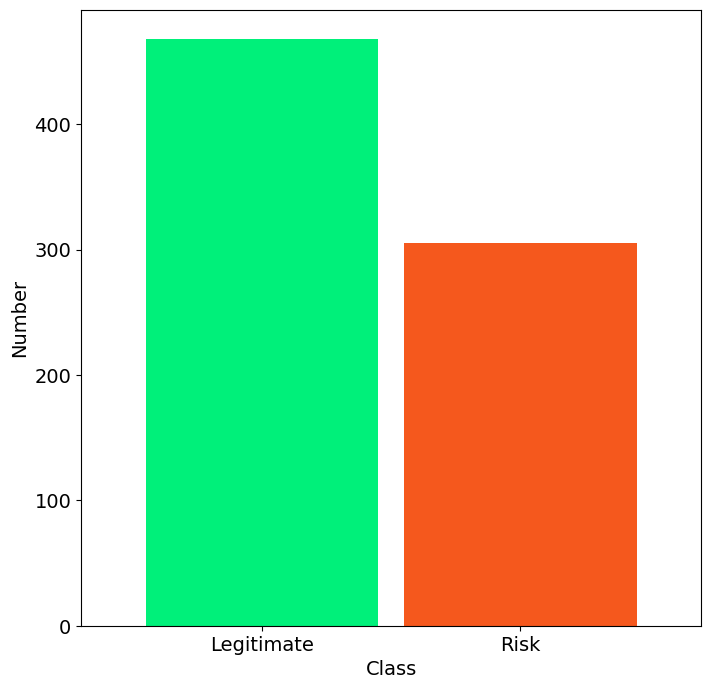

In [11]:
plt.figure(figsize=[8,8])
data.Risk_val.value_counts().plot(kind='bar', width=0.9, color=['#00F07A','#F5581D'])
plt.xlabel('Class',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
X = data.drop(['Risk', 'Risk_val'], axis=1)

In [13]:
X

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.2,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.2,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.2,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,0.2,0.098,0.40,0.2,0.080,0.89,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.578,0.4,0.5,0.3156
772,55.57,16,0.47,0.2,0.094,0.37,0.2,0.074,0.84,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.568,0.4,0.5,0.3136
773,55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.456,0.4,0.5,0.2912
774,55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5.0,...,0.2,0.4,0,0.2,0.0,2.0,1.440,0.4,0.5,0.2880


In [14]:
X.columns

Index(['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk'],
      dtype='object')

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [17]:
X_scaled

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.035172,0.511628,0.049176,1.0,0.049176,0.001977,0.0,0.000659,0.005264,0.00,...,0.0,0.0,0.0,0.0,0.0,0.125,0.008969,0.0,0.0,0.001493
1,0.035172,0.116279,0.000000,0.0,0.000000,0.003819,0.0,0.001273,0.003806,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.001443,0.0,0.0,0.000240
2,0.035172,0.116279,0.006000,0.0,0.002000,0.000182,0.0,0.000061,0.000583,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000185,0.0,0.0,0.000031
3,0.035172,0.116279,0.000000,0.0,0.000000,0.008540,1.0,0.008540,0.008511,0.25,...,0.0,0.0,0.0,0.0,0.0,0.750,0.020166,0.0,0.0,0.003356
4,0.035172,0.116279,0.000000,0.0,0.000000,0.000063,0.0,0.000021,0.000063,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000020,0.0,0.0,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,0.926207,0.186047,0.005765,0.0,0.001922,0.000316,0.0,0.000105,0.000701,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000223,0.0,0.0,0.000037
769,0.926207,0.348837,0.005529,0.0,0.001843,0.000293,0.0,0.000098,0.000662,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000210,0.0,0.0,0.000035
770,0.926207,0.302326,0.002824,0.0,0.000941,0.000032,0.0,0.000011,0.000221,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000070,0.0,0.0,0.000012
771,0.926207,0.395349,0.002353,0.0,0.000784,0.000000,0.0,0.000000,0.000158,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000050,0.0,0.0,0.000008


# Chi-square feature selection technique

In [18]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [19]:
y = data['Risk']

In [20]:
y

0      1
1      0
2      0
3      1
4      0
      ..
771    0
772    0
773    0
774    0
775    0
Name: Risk, Length: 773, dtype: int64

In [21]:
bestfeatures = SelectKBest(score_func=chi2, k=10)

In [22]:
fit_feat = bestfeatures.fit(X_scaled,y)

In [23]:
scores = pd.DataFrame(fit_feat.scores_)
columns = pd.DataFrame(X_scaled.columns)

In [24]:
featureScores = pd.concat([columns,scores],axis=1)
featureScores.columns = ['Specs','Score']

In [25]:
print(featureScores.nlargest(10,'Score'))

    Specs       Score
13     13  255.833129
6       6  197.999586
21     21  155.878689
3       3  147.503320
15     15   93.687438
0       0   67.660876
10     10   65.605757
19     19   47.366627
17     17   46.160847
11     11   38.675973


In [26]:
bestfeatures_list = featureScores.nlargest(10,'Score')['Specs']

In [27]:
bestfeatures_list = bestfeatures_list.tolist()
bestfeatures_list

[13, 6, 21, 3, 15, 0, 10, 19, 17, 11]

In [28]:
X_scaled_best = X_scaled[bestfeatures_list]

In [29]:
X_scaled_best

,13,6,21,3,15,0,10,19,17,11
0,0.0,0.0,0.125,1.0,0.0,0.035172,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000,0.0,0.0,0.035172,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000,0.0,0.0,0.035172,0.0,0.0,0.0,0.000000
3,1.0,1.0,0.750,0.0,0.0,0.035172,1.0,0.0,0.0,0.590909
4,0.0,0.0,0.000,0.0,0.0,0.035172,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
768,0.0,0.0,0.000,0.0,0.0,0.926207,0.0,0.0,0.0,0.000000
769,0.0,0.0,0.000,0.0,0.0,0.926207,0.0,0.0,0.0,0.000000
770,0.0,0.0,0.000,0.0,0.0,0.926207,0.0,0.0,0.0,0.000000
771,0.0,0.0,0.000,0.0,0.0,0.926207,0.0,0.0,0.0,0.000000


In [30]:
y

0      1
1      0
2      0
3      1
4      0
      ..
771    0
772    0
773    0
774    0
775    0
Name: Risk, Length: 773, dtype: int64

In [31]:
selected_features = X.iloc[:, bestfeatures_list]

In [32]:
selected_features.drop(['Score','Score_B.1','District_Loss'], axis=1, inplace=True)

C:\Users\Vladislav\AppData\Local\Temp\ipykernel_20064\1603825507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features.drop(['Score','Score_B.1','District_Loss'], axis=1, inplace=True)


In [33]:
selected_features

,Score_MV,Score_B,Score_A,Sector_score,Prob,RiSk_E,Risk_C
0,0.2,0.2,0.6,3.89,0.2,0.4,1.0
1,0.2,0.2,0.2,3.89,0.2,0.4,1.0
2,0.2,0.2,0.2,3.89,0.2,0.4,1.0
3,0.6,0.6,0.2,3.89,0.2,0.4,3.6
4,0.2,0.2,0.2,3.89,0.2,0.4,1.0
...,...,...,...,...,...,...,...
771,0.2,0.2,0.2,55.57,0.2,0.4,1.0
772,0.2,0.2,0.2,55.57,0.2,0.4,1.0
773,0.2,0.2,0.2,55.57,0.2,0.4,1.0
774,0.2,0.2,0.2,55.57,0.2,0.4,1.0


In [34]:
corr_matrix = selected_features.corr()

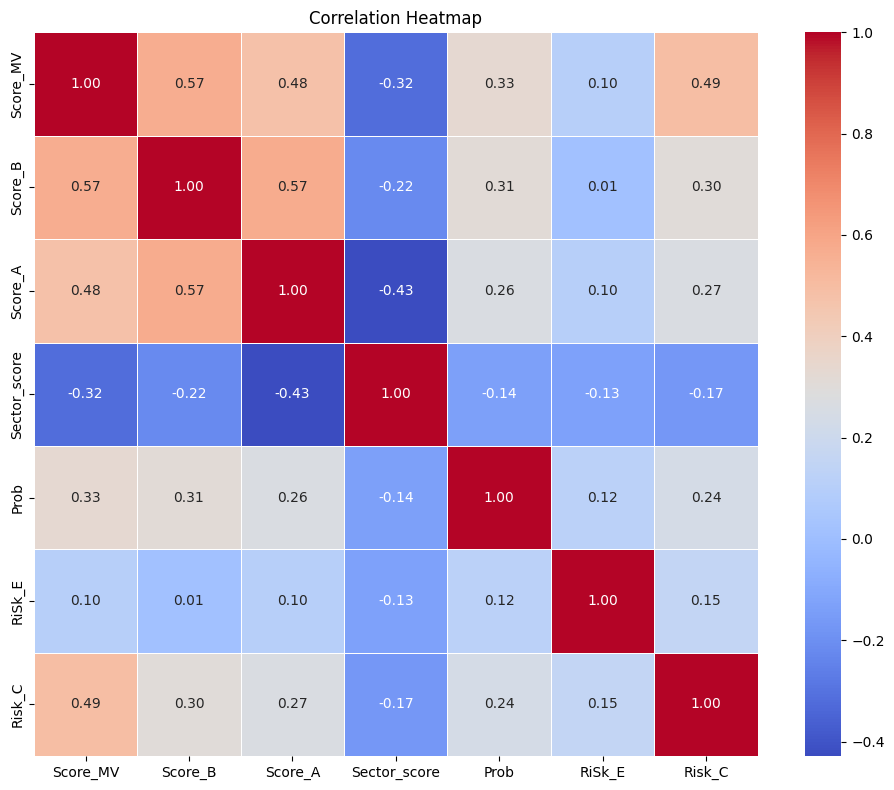

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [36]:
ros = RandomOverSampler(random_state=42)

In [37]:
X_resampled, y_resampled = ros.fit_resample(selected_features, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [39]:
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(X_train))
x_test  = scaler.transform(X_test) 

In [40]:
algorithms = ['Naive Bayes','Support vector machine','Decision tree','Random Forest','XGBoost']

In [41]:
metrics_list = []

In [42]:
matrix_labels = ['Risk','Legitimate']

In [43]:
import sklearn.metrics as metrics

In [44]:
classifiers = [MultinomialNB(), SVC(kernel='linear', probability=True),DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None), 
RandomForestClassifier(n_estimators = 10), xgb.XGBClassifier(random_state=42)]

In [45]:
x_train.columns = [
    "Score_MV", "Score_B", "Score_A",
    "Sector_score", "Prob", "Risk_E", "Risk_C"
]

In [46]:
x_train

,Score_MV,Score_B,Score_A,Sector_score,Prob,Risk_E,Risk_C
0,0.0,0.0,0.0,0.926207,0.0,0.0,0.000000
1,1.0,1.0,1.0,0.015000,0.0,0.0,0.000000
2,1.0,0.0,1.0,0.236379,0.5,0.4,0.590909
3,0.0,0.5,1.0,0.000000,0.0,0.0,0.000000
4,0.0,0.5,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
697,1.0,1.0,1.0,0.035172,0.5,0.0,0.000000
698,0.0,0.0,0.0,0.015000,0.0,0.0,0.000000
699,1.0,0.0,1.0,0.035172,0.0,0.0,0.000000
700,0.0,0.5,1.0,0.000000,0.0,0.0,0.000000


In [47]:
x_test = pd.DataFrame(x_test, columns=x_train.columns)

In [48]:
x_test

,Score_MV,Score_B,Score_A,Sector_score,Prob,Risk_E,Risk_C
0,0.0,0.5,0.5,0.008966,0.0,0.0,0.000000
1,1.0,0.0,0.0,0.035172,0.0,0.0,0.590909
2,0.5,1.0,1.0,0.015000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.926207,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.926207,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
229,0.0,0.0,0.0,0.926207,0.0,0.0,0.000000
230,0.0,0.0,0.0,0.926207,0.0,0.0,0.000000
231,0.0,0.5,0.0,0.008966,0.0,0.2,0.000000
232,0.5,0.0,0.0,0.002414,0.0,0.0,0.000000


# SHAP plots

In [49]:
features = ["Score_MV", "Score_B", "Score_A",
                 "Sector_score", "Prob", "Risk_E", "Risk_C"]

In [50]:
rf = RandomForestClassifier(n_estimators = 10)

In [51]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

In [52]:
importances = rf.feature_importances_

In [53]:
importance_df = pd.DataFrame({
    "Feature": x_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

In [54]:
colors = [
    "tab:blue", "tab:orange", "tab:green",
    "tab:red", "tab:purple", "tab:brown", "tab:pink"
]

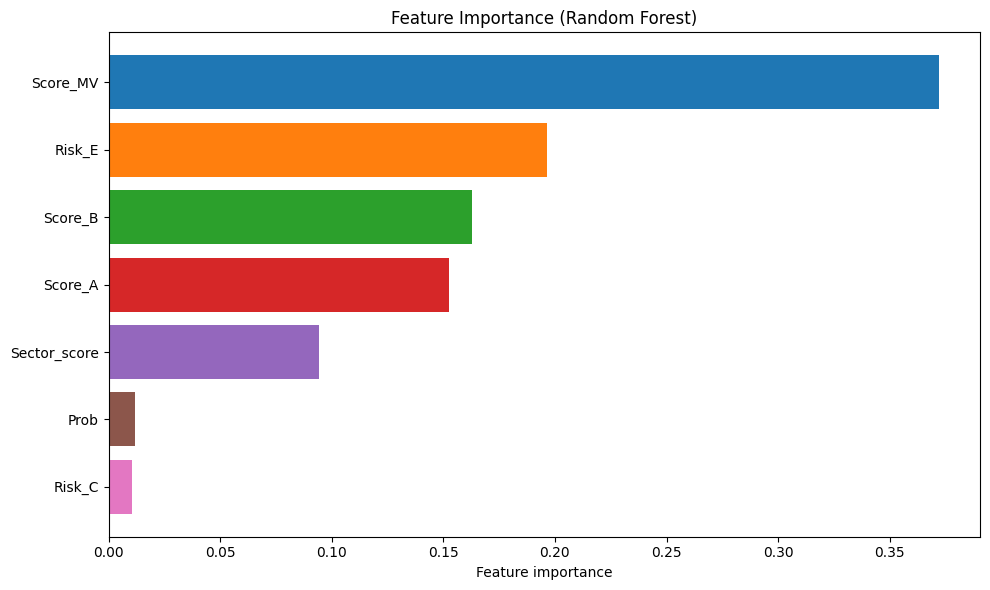

In [55]:
plt.figure(figsize=(10, 6))

plt.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color=colors
)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [56]:
def get_shap_explainer(model, X_background):
    if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier)):
        return shap.TreeExplainer(model)
    else:
        return shap.KernelExplainer(model.predict_proba, X_background)


================ Naive Bayes =================


100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:01<00:00, 131.05it/s]


<Figure size 1400x900 with 0 Axes>

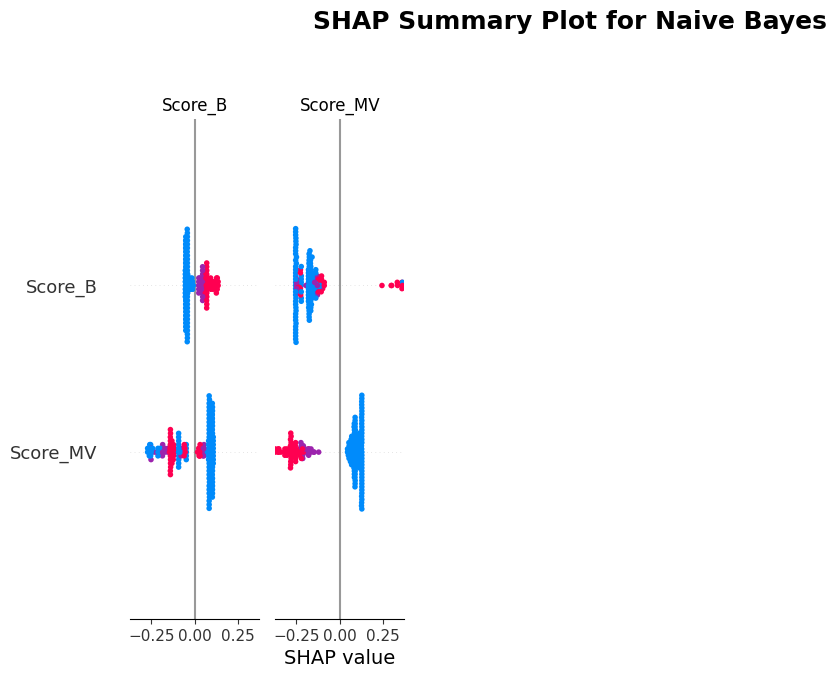


================ Support vector machine =================


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:09<00:00, 25.68it/s]


<Figure size 1400x900 with 0 Axes>

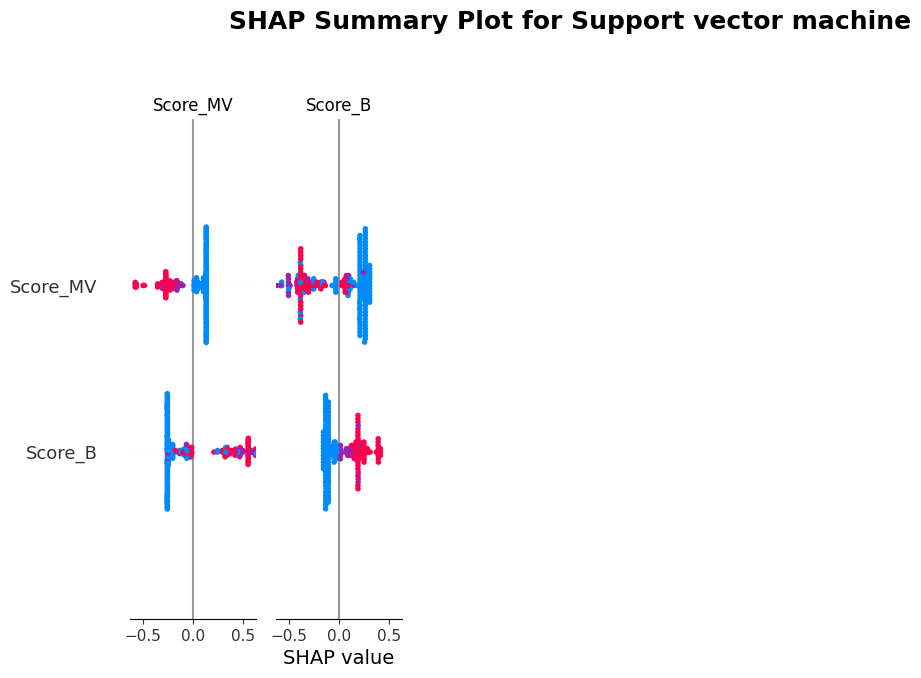


================ Decision tree =================


<Figure size 1400x900 with 0 Axes>

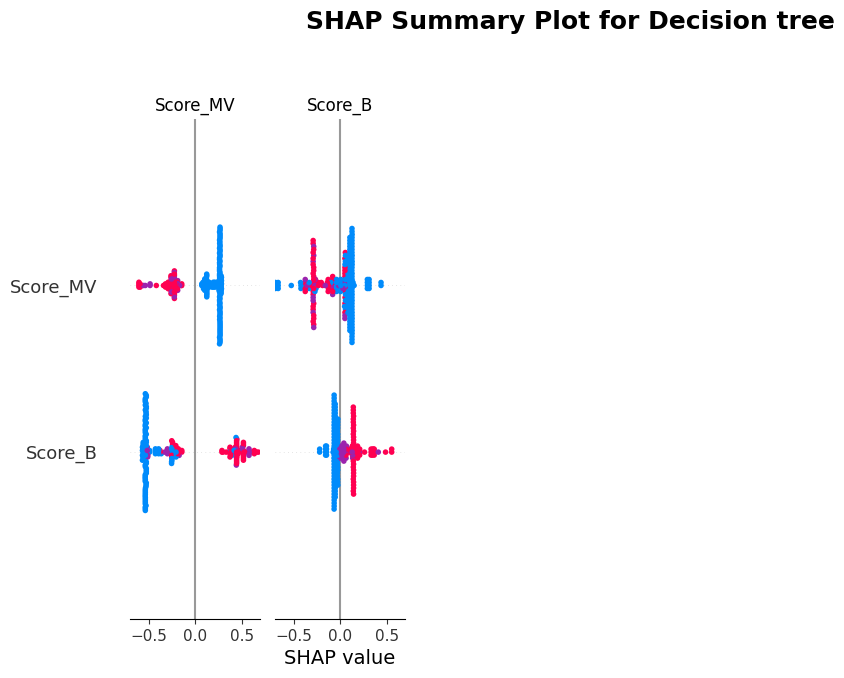


================ Random Forest =================


<Figure size 1400x900 with 0 Axes>

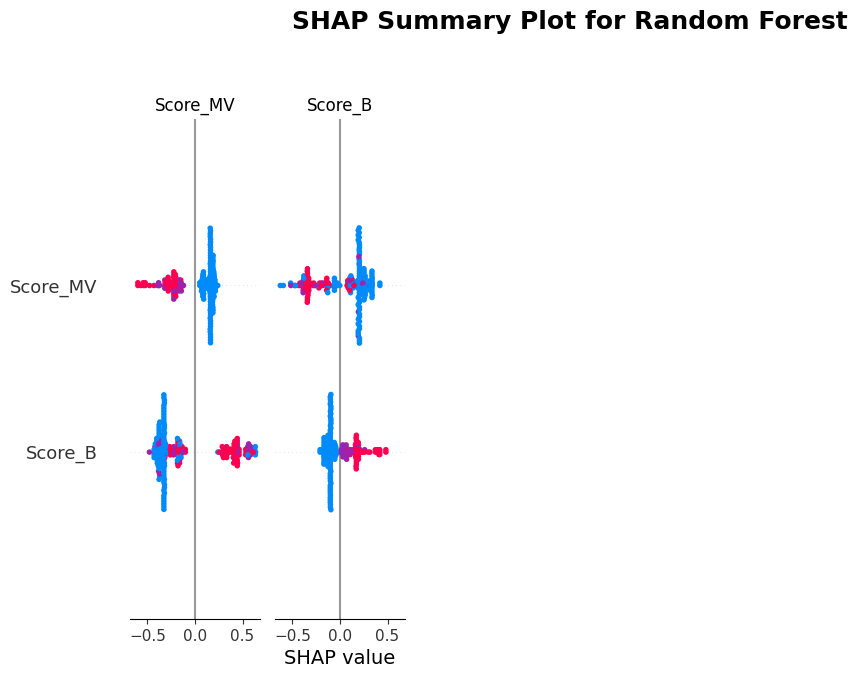


================ XGBoost =================


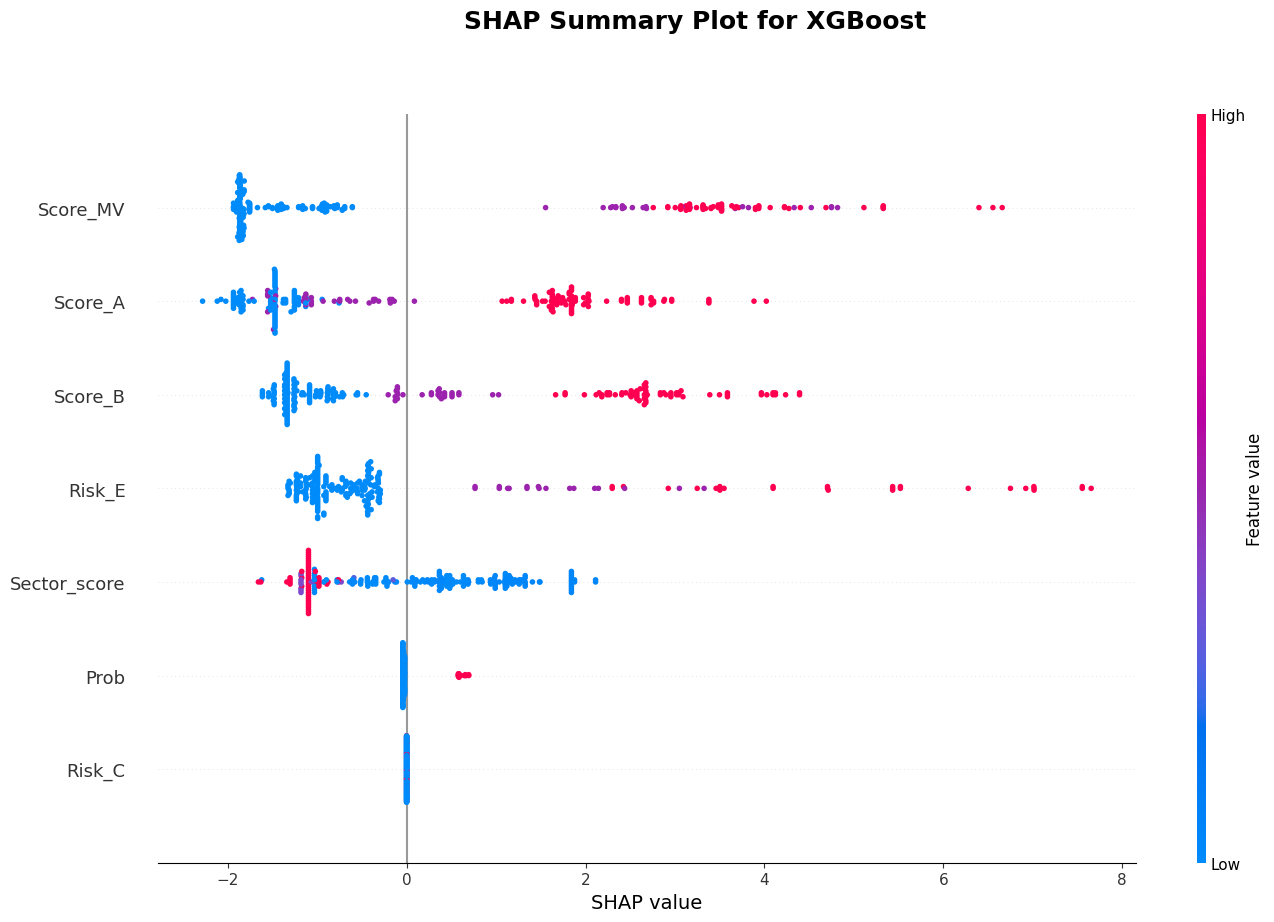

In [57]:
for name, model in zip(algorithms, classifiers):
    print(f"\n================ {name} =================")

    model.fit(x_train, y_train)
    background = shap.sample(x_train, 100)
    explainer = get_shap_explainer(model, background)
    shap_values = explainer.shap_values(x_test)

    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values

    plt.figure(figsize=(14, 9))
    
    shap.summary_plot(
        shap_vals,
        x_test,
        show=False,
        plot_size=(14, 9),
        max_display=7
    )
        
    plt.suptitle(
        f"SHAP Summary Plot for {name}",
        fontsize=18,
        fontweight="bold",
        y=1.02
    )
    
    plt.xlabel("SHAP value", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [58]:
k = 0
cv = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list = {}
precision_list = {}
recall_list = {}
f1_list = {}

train_time_list = {}
inference_time_list = {}

for i in classifiers:
    val_scores = cross_validate(i, x_train, y_train, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=cv)     
    y_pred_train = cross_val_predict(i, x_train, y_train, cv=cv)

    accuracy_train = val_scores['test_accuracy'].mean()
    accuracy_list[f"{algorithms[k]} accuracy"] = np.round(val_scores['test_accuracy'], 3)
    
    precision_train = val_scores['test_precision'].mean()
    precision_list[f"{algorithms[k]} precision"] = np.round(val_scores['test_precision'], 3)
    
    recall_train = val_scores['test_recall'].mean()
    recall_list[f"{algorithms[k]} recall"] = np.round(val_scores['test_recall'], 3)
    
    f1_train = val_scores['test_f1'].mean()
    f1_list[f"{algorithms[k]} f1"] = np.round(val_scores['test_f1'], 3)
    
    std_accuracy = val_scores['test_accuracy'].std()
    std_precision = val_scores['test_precision'].std()
    std_recall = val_scores['test_recall'].std()
    std_f1 = val_scores['test_f1'].std()

    # TRAINING TIME
    start_train = time.perf_counter()
    i.fit(x_train, y_train)
    end_train = time.perf_counter()

    training_time = end_train - start_train
    train_time_list[algorithms[k]] = training_time

    # INFERENCE TIME
    start_pred = time.perf_counter()
    y_pred_test = i.predict(x_test)
    end_pred = time.perf_counter()

    inference_time_total = end_pred - start_pred
    inference_time_per_sample = inference_time_total / len(x_test)

    inference_time_list[algorithms[k]] = inference_time_per_sample

    fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, y_pred_train)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
       
    y_pred_test = i.predict(x_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, y_pred_test)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
    auc_pr = average_precision_score(y_test, y_pred_test)
    
    brier = brier_score_loss(y_test, y_pred_test)

    calib_true, calib_pred = calibration_curve(
        y_test, y_pred_test, n_bins=10, strategy="uniform"
    )
    
    metrics_list.append({'Accuracy': accuracy_test,
                        'Precision': precision_test,
                        'Recall': recall_test,
                        'F1-score': f1_test,
                        'fpr': fpr_test,
                        'tpr': tpr_test,
                        'auc': roc_auc_test,
                        'auc_pr': auc_pr,
                        'pr_curve': pr_curve,
                        'rec_curve': rec_curve,
                        'thresholds_curve': thresholds_curve,
                        'brier': brier,
                        'calib_true': calib_true,
                        'calib_pred': calib_pred})
    
    print("Evaluation metrics of " + algorithms[k]+" algorithm: ")
    
    print("Training scores: ")
    print(f"Accuracy = {accuracy_train:.3f} ± {std_accuracy:.3f}")
    print(f"Precision = {precision_train:.3f} ± {std_precision:.3f}")
    print(f"Recall = {recall_train:.3f} ± {std_recall:.3f}")
    print(f"F1-score = {f1_train:.3f} ± {std_f1:.3f}")

    print("Test scores: ")
    print('Accuracy - ', round(accuracy_test, 3))  
    print('Precision - ', round(precision_test, 3))
    print('Recall - ', round(recall_test, 3))
    print('F1-score - ', round(f1_test, 3))
    print(" ")
    print("Efficiency:")
    print(f"Training time (s): {training_time:.4f}")
    print(f"Inference time per sample (ms): {inference_time_per_sample * 1000:.4f}")
    print(" ")
    k = k + 1

Evaluation metrics of Naive Bayes algorithm: 
Training scores: 
Accuracy = 0.849 ± 0.030
Precision = 0.787 ± 0.028
Recall = 0.953 ± 0.048
F1-score = 0.862 ± 0.034
Test scores: 
Accuracy -  0.846
Precision -  0.785
Recall -  0.958
F1-score -  0.863
 
Efficiency:
Training time (s): 0.0017
Inference time per sample (ms): 0.0035
 
Evaluation metrics of Support vector machine algorithm: 
Training scores: 
Accuracy = 0.959 ± 0.015
Precision = 0.965 ± 0.024
Recall = 0.951 ± 0.017
F1-score = 0.958 ± 0.017
Test scores: 
Accuracy -  0.949
Precision -  0.942
Recall -  0.958
F1-score -  0.95
 
Efficiency:
Training time (s): 0.0117
Inference time per sample (ms): 0.0068
 
Evaluation metrics of Decision tree algorithm: 
Training scores: 
Accuracy = 0.957 ± 0.009
Precision = 0.968 ± 0.016
Recall = 0.945 ± 0.020
F1-score = 0.956 ± 0.011
Test scores: 
Accuracy -  0.957
Precision -  0.958
Recall -  0.958
F1-score -  0.958
 
Efficiency:
Training time (s): 0.0015
Inference time per sample (ms): 0.0075
 
E

In [59]:
accuracy_list

{'Naive Bayes accuracy': array([0.801, 0.858, 0.857, 0.836, 0.893]),
 'Support vector machine accuracy': array([0.936, 0.957, 0.979, 0.971, 0.95 ]),
 'Decision tree accuracy': array([0.95 , 0.965, 0.95 , 0.971, 0.95 ]),
 'Random Forest accuracy': array([0.957, 0.95 , 0.95 , 0.971, 0.943]),
 'XGBoost accuracy': array([0.95 , 0.965, 0.95 , 0.964, 0.95 ])}

In [60]:
precision_list

{'Naive Bayes precision': array([0.747, 0.798, 0.778, 0.783, 0.831]),
 'Support vector machine precision': array([0.938, 0.944, 1.   , 0.986, 0.957]),
 'Decision tree precision': array([0.983, 0.971, 0.944, 0.986, 0.957]),
 'Random Forest precision': array([1.   , 0.97 , 0.944, 0.986, 0.943]),
 'XGBoost precision': array([0.983, 0.971, 0.944, 0.986, 0.957])}

In [61]:
recall_list

{'Naive Bayes recall': array([0.862, 0.957, 1.   , 0.96 , 0.986]),
 'Support vector machine recall': array([0.923, 0.971, 0.957, 0.96 , 0.943]),
 'Decision tree recall': array([0.908, 0.957, 0.957, 0.96 , 0.943]),
 'Random Forest recall': array([0.908, 0.929, 0.957, 0.96 , 0.943]),
 'XGBoost recall': array([0.908, 0.957, 0.957, 0.947, 0.943])}

In [62]:
f1_list

{'Naive Bayes f1': array([0.8  , 0.87 , 0.875, 0.862, 0.902]),
 'Support vector machine f1': array([0.93 , 0.958, 0.978, 0.973, 0.95 ]),
 'Decision tree f1': array([0.944, 0.964, 0.95 , 0.973, 0.95 ]),
 'Random Forest f1': array([0.952, 0.949, 0.95 , 0.973, 0.943]),
 'XGBoost f1': array([0.944, 0.964, 0.95 , 0.966, 0.95 ])}

In [63]:
def paired_ttests_each_vs_others(metric_dict):
    models = list(metric_dict.keys())

    print("\nEach model vs all other models (paired t-test)")
    print("-" * 80)

    for model_a in models:
        print(f"\n=== {model_a} ===")
        for model_b in models:
            if model_b == model_a:
                continue

            t_stat, p_value = ttest_rel(metric_dict[model_a], metric_dict[model_b])

            print(f"{model_a:30s} vs {model_b:30s} | "
                  f"t = {t_stat:7.3f} | p = {p_value:.4f}")

In [64]:
print("Accuracy t-test and p-value scores\n")
paired_ttests_each_vs_others(accuracy_list)

Accuracy t-test and p-value scores


Each model vs all other models (paired t-test)
--------------------------------------------------------------------------------

=== Naive Bayes accuracy ===
Naive Bayes accuracy           vs Support vector machine accuracy | t =  -7.455 | p = 0.0017
Naive Bayes accuracy           vs Decision tree accuracy         | t =  -6.687 | p = 0.0026
Naive Bayes accuracy           vs Random Forest accuracy         | t =  -5.689 | p = 0.0047
Naive Bayes accuracy           vs XGBoost accuracy               | t =  -6.823 | p = 0.0024

=== Support vector machine accuracy ===
Support vector machine accuracy vs Naive Bayes accuracy           | t =   7.455 | p = 0.0017
Support vector machine accuracy vs Decision tree accuracy         | t =   0.190 | p = 0.8589
Support vector machine accuracy vs Random Forest accuracy         | t =   0.549 | p = 0.6120
Support vector machine accuracy vs XGBoost accuracy               | t =   0.376 | p = 0.7262

=== Decision tree accu

In [65]:
print("Precision t-test and p-value scores\n")
paired_ttests_each_vs_others(precision_list)

Precision t-test and p-value scores


Each model vs all other models (paired t-test)
--------------------------------------------------------------------------------

=== Naive Bayes precision ===
Naive Bayes precision          vs Support vector machine precision | t =  -9.884 | p = 0.0006
Naive Bayes precision          vs Decision tree precision        | t =  -9.789 | p = 0.0006
Naive Bayes precision          vs Random Forest precision        | t =  -7.821 | p = 0.0014
Naive Bayes precision          vs XGBoost precision              | t =  -9.789 | p = 0.0006

=== Support vector machine precision ===
Support vector machine precision vs Naive Bayes precision          | t =   9.884 | p = 0.0006
Support vector machine precision vs Decision tree precision        | t =  -0.187 | p = 0.8606
Support vector machine precision vs Random Forest precision        | t =  -0.182 | p = 0.8641
Support vector machine precision vs XGBoost precision              | t =  -0.187 | p = 0.8606

=== Decision t

In [66]:
print("Recall t-test and p-value scores\n")
paired_ttests_each_vs_others(recall_list)

Recall t-test and p-value scores


Each model vs all other models (paired t-test)
--------------------------------------------------------------------------------

=== Naive Bayes recall ===
Naive Bayes recall             vs Support vector machine recall  | t =   0.113 | p = 0.9155
Naive Bayes recall             vs Decision tree recall           | t =   0.483 | p = 0.6545
Naive Bayes recall             vs Random Forest recall           | t =   0.807 | p = 0.4647
Naive Bayes recall             vs XGBoost recall                 | t =   0.644 | p = 0.5547

=== Support vector machine recall ===
Support vector machine recall  vs Naive Bayes recall             | t =  -0.113 | p = 0.9155
Support vector machine recall  vs Decision tree recall           | t =   1.631 | p = 0.1781
Support vector machine recall  vs Random Forest recall           | t =   1.393 | p = 0.2360
Support vector machine recall  vs XGBoost recall                 | t =   2.439 | p = 0.0713

=== Decision tree recall ===
Deci

In [67]:
print("F1-score t-test and p-value scores\n")
paired_ttests_each_vs_others(f1_list)

F1-score t-test and p-value scores


Each model vs all other models (paired t-test)
--------------------------------------------------------------------------------

=== Naive Bayes f1 ===
Naive Bayes f1                 vs Support vector machine f1      | t =  -6.966 | p = 0.0022
Naive Bayes f1                 vs Decision tree f1               | t =  -5.818 | p = 0.0043
Naive Bayes f1                 vs Random Forest f1               | t =  -4.890 | p = 0.0081
Naive Bayes f1                 vs XGBoost f1                     | t =  -5.840 | p = 0.0043

=== Support vector machine f1 ===
Support vector machine f1      vs Naive Bayes f1                 | t =   6.966 | p = 0.0022
Support vector machine f1      vs Decision tree f1               | t =   0.226 | p = 0.8323
Support vector machine f1      vs Random Forest f1               | t =   0.546 | p = 0.6144
Support vector machine f1      vs XGBoost f1                     | t =   0.420 | p = 0.6960

=== Decision tree f1 ===
Decision tree 

In [68]:
x_train.shape

(702, 7)

In [69]:
x_test.shape

(234, 7)

In [70]:
model_dnn = Sequential()
model_dnn.add(Dense(256, input_dim=7, kernel_regularizer=l2(1e-4)))
model_dnn.add(Activation('relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(128, kernel_regularizer=l2(1e-4)))
model_dnn.add(Activation('relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(1))
model_dnn.add(Activation('sigmoid'))
model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.9)])
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [71]:
start_train = time.perf_counter()

In [72]:
history_dnn = model_dnn.fit(x_train, y_train, batch_size = 14000, epochs = 100, verbose=1, validation_split=0.125)
loss_dnn, accuracy_dnn, precision_dnn, recall_dnn, f1_score_dnn = model_dnn.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy_dnn))
loss_dnn, accuracy_dnn, precision_dnn, recall_dnn, f1_score_dnn = model_dnn.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: {:.4f}".format(accuracy_dnn))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.7196 - accuracy: 0.5261 - precision: 0.5607 - recall: 0.1974 - fbeta_score: 0.0000e+00 - val_loss: 0.6900 - val_accuracy: 0.8068 - val_precision: 0.7458 - val_recall: 0.9565 - val_fbeta_score: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6966 - accuracy: 0.6596 - precision: 0.7056 - recall: 0.5362 - fbeta_score: 0.0000e+00 - val_loss: 0.6655 - val_accuracy: 0.8523 - val_precision: 0.8000 - val_recall: 0.9565 - val_fbeta_score: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 0.6712 - accuracy: 0.8078 - precision: 0.7719 - recall: 0.8684 - fbeta_score: 0.0000e+00 - val_loss: 0.6427 - val_accuracy: 0.8864 - val_precision: 0.8333 - val_recall: 0.9783 - val_fbeta_score: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 0.6506 - accuracy: 0.8485 - precision: 0.7813 - recall: 0.9638 - fbeta_score: 0.0000e+00 - val_l

In [73]:
end_train = time.perf_counter()

total_training_time = end_train - start_train
avg_epoch_time = total_training_time / 100

print(f"Total training time (s): {total_training_time:.2f}")
print(f"Average training time per epoch (s): {avg_epoch_time:.2f}")

Total training time (s): 9.75
Average training time per epoch (s): 0.10


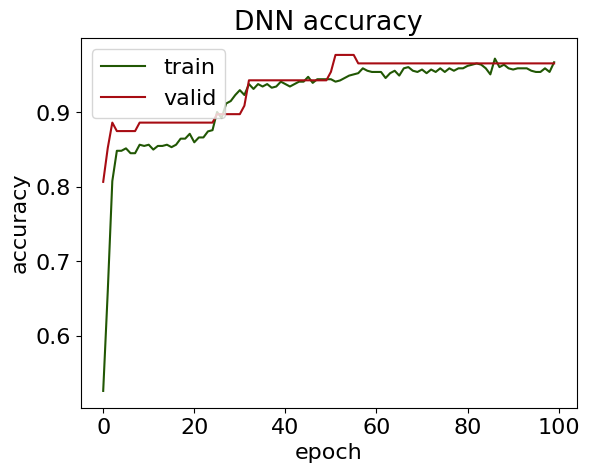

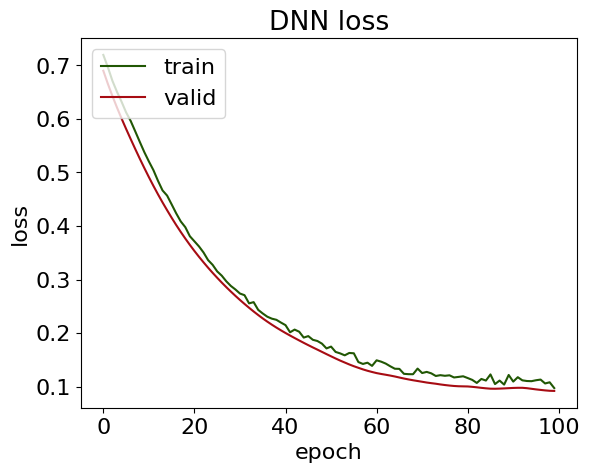

In [74]:
#plot for accuracy
plt.rcParams['font.size'] = 16
plt.plot(history_dnn.history['accuracy'], color='#215704')
plt.plot(history_dnn.history['val_accuracy'], color='#A70C13')
plt.title('DNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#plot for loss
plt.plot(history_dnn.history['loss'], color='#215704')
plt.plot(history_dnn.history['val_loss'], color='#A70C13')
plt.title('DNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [75]:
val_accuracy_list = np.array(history_dnn.history['val_accuracy'])
val_accuracy = round(np.mean(val_accuracy_list), 3)

val_precision_list = np.array(history_dnn.history['val_precision'])
val_precision = round(np.mean(val_precision_list), 3)

val_recall_list = np.array(history_dnn.history['val_recall'])
val_recall = round(np.mean(val_recall_list), 3)

val_f1_list = np.array(history_dnn.history['val_fbeta_score'])
val_f1 = round(np.mean(val_f1_list), 3)

In [76]:
y_pred_test = model_dnn.predict(x_test)

8/8 [==============================] - 0s 4ms/step


In [77]:
y_pred_test = list(map(lambda x: 0 if x<0.5 else 1, y_pred_test))

In [78]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

In [79]:
print("Scores:")
print("Accuracy - ", round(accuracy_test, 3))
print("Precision - ", round(precision_test, 3))
print("Recall - ", round(recall_test, 3))
print("F1-score - ", round(f1_score_test, 3))

Scores:
Accuracy -  0.949
Precision -  0.934
Recall -  0.966
F1-score -  0.95


In [80]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

In [81]:
pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
auc_pr = average_precision_score(y_test, y_pred_test)

In [82]:
brier = brier_score_loss(y_test, y_pred_test)

calib_true, calib_pred = calibration_curve(
    y_test, y_pred_test, n_bins=10, strategy="uniform"
)

metrics_list.append({'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1-score': f1_test,
                    'fpr': fpr_test,
                    'tpr': tpr_test,
                    'auc': roc_auc_test,
                    'auc_pr': auc_pr,
                    'pr_curve': pr_curve,
                    'rec_curve': rec_curve,
                    'thresholds_curve': thresholds_curve,
                    'brier': brier,
                    'calib_true': calib_true,
                    'calib_pred': calib_pred})

In [83]:
labels = [0,1]

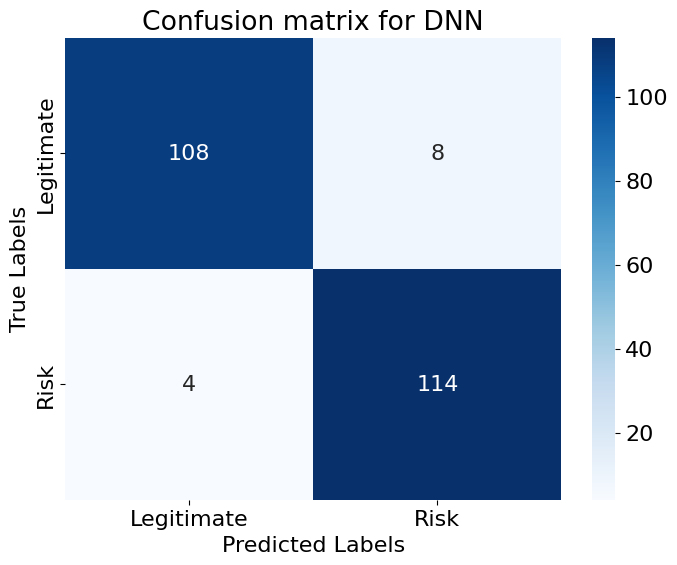

In [84]:
cm = confusion_matrix(y_test, y_pred_test, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels], yticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix for DNN")
plt.show()

In [85]:
max_features = 10
nb_filter = 250
filter_length = 3
hidden_dims = 250

In [86]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=5e-5)

In [87]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(7, 1), kernel_regularizer=l2(1e-4)))
model_cnn.add(BatchNormalization())
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(hidden_dims, activation='relu', kernel_regularizer=l2(1e-4)))

model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.00008)

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.9)
    ]
)

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 250)            1000      
                                                                 
 batch_normalization (BatchN  (None, 5, 250)           1000      
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 250)               62750     
                                                                 
 dense_4 (Dense)             (None, 128)               32128     
                                                                 
 dense_5 (Dense)             (None, 64)               

In [88]:
start_train = time.perf_counter()

In [89]:
history_cnn = model_cnn.fit(x_train, y_train, batch_size = 2000, epochs = 100, callbacks=[reduce_lr], verbose=1, validation_split=0.125)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.7025 - accuracy: 0.6352 - precision: 0.8448 - recall: 0.3224 - fbeta_score: 0.0000e+00 - val_loss: 0.7176 - val_accuracy: 0.5682 - val_precision: 0.6111 - val_recall: 0.4783 - val_fbeta_score: 0.0000e+00 - lr: 8.0000e-05
Epoch 2/100
1/1 [==============================] - 0s 79ms/step - loss: 0.6819 - accuracy: 0.7166 - precision: 0.8571 - recall: 0.5132 - fbeta_score: 0.0000e+00 - val_loss: 0.7167 - val_accuracy: 0.7045 - val_precision: 0.7083 - val_recall: 0.7391 - val_fbeta_score: 0.0000e+00 - lr: 8.0000e-05
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.6635 - accuracy: 0.7704 - precision: 0.8791 - recall: 0.6217 - fbeta_score: 0.0000e+00 - val_loss: 0.7158 - val_accuracy: 0.7614 - val_precision: 0.7358 - val_recall: 0.8478 - val_fbeta_score: 0.0000e+00 - lr: 8.0000e-05
Epoch 4/100
1/1 [==============================] - 0s 83ms/step - loss: 0.6456 - accuracy: 0.7932 - precision: 0.8831

In [90]:
end_train = time.perf_counter()

total_training_time = end_train - start_train
avg_epoch_time = total_training_time / 100

print(f"Total training time (s): {total_training_time:.2f}")
print(f"Average training time per epoch (s): {avg_epoch_time:.2f}")

Total training time (s): 10.01
Average training time per epoch (s): 0.10


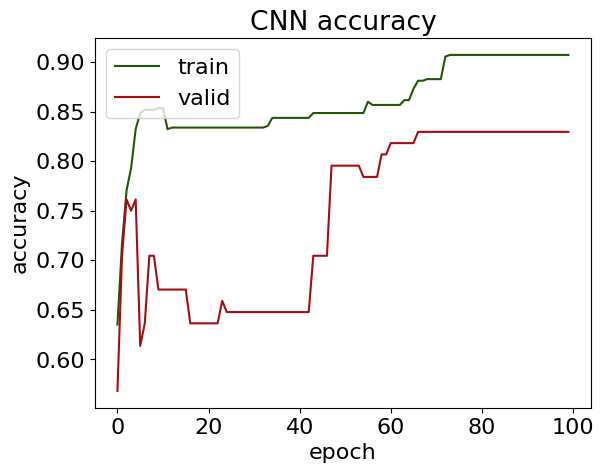

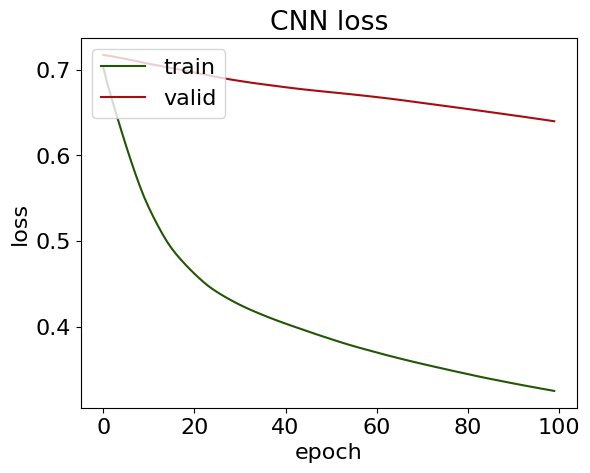

In [91]:
#plot for accuracy
plt.rcParams['font.size'] = 16
plt.plot(history_cnn.history['accuracy'], color='#215704')
plt.plot(history_cnn.history['val_accuracy'], color='#A70C13')
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#plot for loss
plt.plot(history_cnn.history['loss'], color='#215704')
plt.plot(history_cnn.history['val_loss'], color='#A70C13')
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [92]:
val_accuracy_list = np.array(history_cnn.history['val_accuracy'])
val_accuracy = round(np.mean(val_accuracy_list), 3)

val_precision_list = np.array(history_cnn.history['val_precision'])
val_precision = round(np.mean(val_precision_list), 3)

val_recall_list = np.array(history_cnn.history['val_recall'])
val_recall = round(np.mean(val_recall_list), 3)

val_f1_list = np.array(history_cnn.history['val_fbeta_score'])
val_f1 = round(np.mean(val_f1_list), 3)

In [93]:
y_pred_test = model_cnn.predict(x_test)

8/8 [==============================] - 0s 16ms/step


In [94]:
y_pred_test = list(map(lambda x: 0 if x<0.5 else 1, y_pred_test))

In [95]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

In [96]:
print("Scores training:")
print("Accuracy - ", round(accuracy_test, 3))
print("Precision - ", round(precision_test, 3))
print("Recall - ", round(recall_test, 3))
print("F1-score - ", round(f1_score_test, 3))

Scores training:
Accuracy -  0.833
Precision -  0.838
Recall -  0.831
F1-score -  0.834


In [97]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

In [98]:
pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
auc_pr = average_precision_score(y_test, y_pred_test)

In [99]:
brier = brier_score_loss(y_test, y_pred_test)

calib_true, calib_pred = calibration_curve(
    y_test, y_pred_test, n_bins=10, strategy="uniform"
)

metrics_list.append({'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1-score': f1_test,
                    'fpr': fpr_test,
                    'tpr': tpr_test,
                    'auc': roc_auc_test,
                    'auc_pr': auc_pr,
                    'pr_curve': pr_curve,
                    'rec_curve': rec_curve,
                    'thresholds_curve': thresholds_curve,
                    'brier': brier,
                    'calib_true': calib_true,
                    'calib_pred': calib_pred})

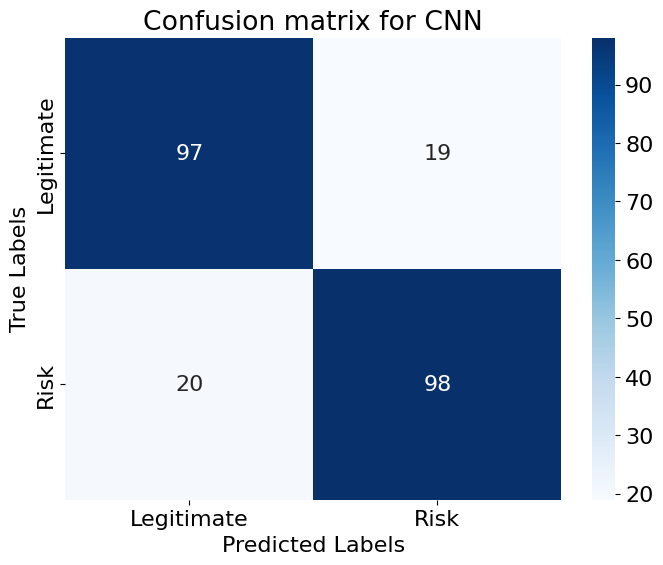

In [100]:
cm = confusion_matrix(y_test, y_pred_test, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels], yticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix for CNN")
plt.show()

In [101]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(7,1), return_sequences=True, kernel_regularizer=l2(1e-4),))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(32, kernel_regularizer=l2(1e-4),))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model_lstm.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', Precision(), Recall(), tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.9)])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 spatial_dropout1d (SpatialD  (None, 7, 128)           0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
__________________________________________________

In [102]:
start_train = time.perf_counter()

In [103]:
history_lstm = model_lstm.fit(x_train, y_train, batch_size = 14000, epochs = 100, verbose=1, validation_split=0.125)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.7052 - accuracy: 0.5000 - precision_1: 0.4966 - recall_1: 0.7138 - fbeta_score: 0.0000e+00 - val_loss: 0.7008 - val_accuracy: 0.6818 - val_precision_1: 0.6452 - val_recall_1: 0.8696 - val_fbeta_score: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 118ms/step - loss: 0.7015 - accuracy: 0.6987 - precision_1: 0.6462 - recall_1: 0.8651 - fbeta_score: 0.0000e+00 - val_loss: 0.6967 - val_accuracy: 0.6932 - val_precision_1: 0.6557 - val_recall_1: 0.8696 - val_fbeta_score: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 117ms/step - loss: 0.6978 - accuracy: 0.7362 - precision_1: 0.6732 - recall_1: 0.9079 - fbeta_score: 0.0000e+00 - val_loss: 0.6925 - val_accuracy: 0.6818 - val_precision_1: 0.6500 - val_recall_1: 0.8478 - val_fbeta_score: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 86ms/step - loss: 0.6942 - accuracy: 0.7264 - precision_1: 0.6635 - recall_1: 0.9079 - f

In [104]:
end_train = time.perf_counter()

total_training_time = end_train - start_train
avg_epoch_time = total_training_time / 100

print(f"Total training time (s): {total_training_time:.2f}")
print(f"Average training time per epoch (s): {avg_epoch_time:.2f}")

Total training time (s): 11.60
Average training time per epoch (s): 0.12


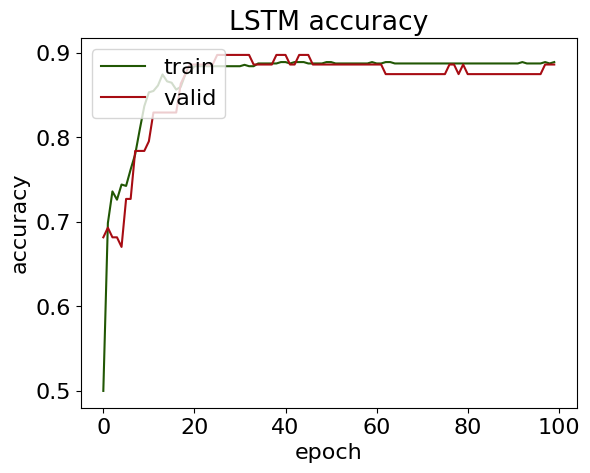

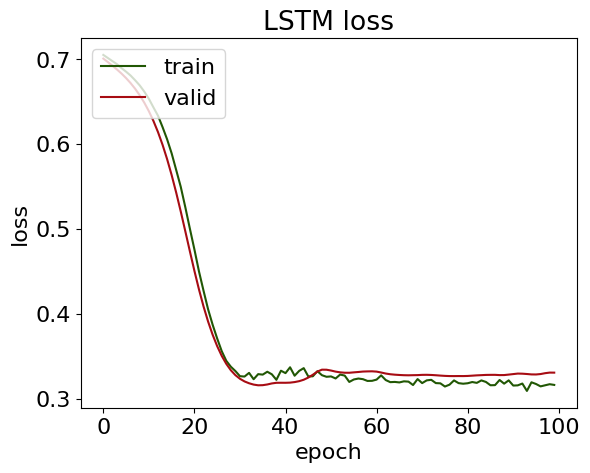

In [106]:
#plot for accuracy
plt.rcParams['font.size'] = 16
plt.plot(history_lstm.history['accuracy'], color='#215704')
plt.plot(history_lstm.history['val_accuracy'], color='#A70C13')
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#plot for loss
plt.plot(history_lstm.history['loss'], color='#215704')
plt.plot(history_lstm.history['val_loss'], color='#A70C13')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [107]:
val_accuracy_list = np.array(history_lstm.history['val_accuracy'])
val_accuracy = round(np.mean(val_accuracy_list), 3)

val_precision_list = np.array(history_lstm.history['val_precision_1'])
val_precision = round(np.mean(val_precision_list), 3)

val_recall_list = np.array(history_lstm.history['val_recall_1'])
val_recall = round(np.mean(val_recall_list), 3)

val_f1_list = np.array(history_lstm.history['val_fbeta_score'])
val_f1 = round(np.mean(val_f1_list), 3)

In [108]:
y_pred_test = model_lstm.predict(x_test)

8/8 [==============================] - 1s 6ms/step


In [109]:
y_pred_test = list(map(lambda x: 0 if x<0.5 else 1, y_pred_test))

In [110]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

In [111]:
print("Scores training:")
print("Accuracy - ", round(accuracy_test, 3))
print("Precision - ", round(precision_test, 3))
print("Recall - ", round(recall_test, 3))
print("F1-score - ", round(f1_score_test, 3))

Scores training:
Accuracy -  0.889
Precision -  0.942
Recall -  0.831
F1-score -  0.883


In [112]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

In [113]:
pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
auc_pr = average_precision_score(y_test, y_pred_test)

In [114]:
brier = brier_score_loss(y_test, y_pred_test)

calib_true, calib_pred = calibration_curve(
    y_test, y_pred_test, n_bins=10, strategy="uniform"
)

metrics_list.append({'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1-score': f1_test,
                    'fpr': fpr_test,
                    'tpr': tpr_test,
                    'auc': roc_auc_test,
                    'auc_pr': auc_pr,
                    'pr_curve': pr_curve,
                    'rec_curve': rec_curve,
                    'thresholds_curve': thresholds_curve,
                    'brier': brier,
                    'calib_true': calib_true,
                    'calib_pred': calib_pred})

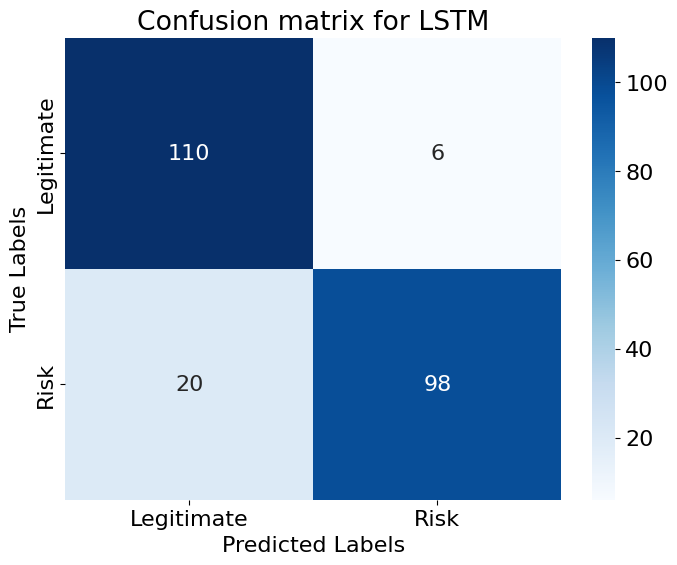

In [115]:
cm = confusion_matrix(y_test, y_pred_test, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels], yticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix for LSTM")
plt.show()

In [116]:
model_cnn_lstm = Sequential()

# CNN layers
model_cnn_lstm.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(7, 1), kernel_regularizer=l2(1e-4)))
model_cnn_lstm.add(GlobalMaxPooling1D())
model_cnn_lstm.add(Dense(hidden_dims, activation='relu', kernel_regularizer=l2(1e-4)))

# Reshape for LSTM input (batch_size, timesteps, features)
model_cnn_lstm.add(Reshape((1, hidden_dims)))

# LSTM layers
model_cnn_lstm.add(LSTM(128, return_sequences=False))

# Fully connected layers
model_cnn_lstm.add(Dense(64, activation='relu'))
model_cnn_lstm.add(Dense(32, activation='relu'))

# Output layer
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, 
                        metrics=['accuracy', Precision(), Recall(), tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.9)])

# Model summary
model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 250)            1000      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 250)               62750     
                                                                 
 reshape (Reshape)           (None, 1, 250)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               194048    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                      

In [117]:
start_train = time.perf_counter()

In [118]:
history_cnn_lstm = model_cnn_lstm.fit(x_train, y_train, batch_size = 2000, epochs = 100, verbose=1, validation_split=0.125)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7187 - accuracy: 0.2231 - precision_2: 0.2126 - recall_2: 0.2105 - fbeta_score: 0.0000e+00 - val_loss: 0.7185 - val_accuracy: 0.5682 - val_precision_2: 0.7500 - val_recall_2: 0.2609 - val_fbeta_score: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 132ms/step - loss: 0.7184 - accuracy: 0.6531 - precision_2: 0.8699 - recall_2: 0.3520 - fbeta_score: 0.0000e+00 - val_loss: 0.7182 - val_accuracy: 0.6932 - val_precision_2: 0.8065 - val_recall_2: 0.5435 - val_fbeta_score: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 89ms/step - loss: 0.7180 - accuracy: 0.7818 - precision_2: 0.8632 - recall_2: 0.6645 - fbeta_score: 0.0000e+00 - val_loss: 0.7179 - val_accuracy: 0.7727 - val_precision_2: 0.7955 - val_recall_2: 0.7609 - val_fbeta_score: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 107ms/step - loss: 0.7177 - accuracy: 0.8306 - precision_2: 0.8571 - recall_2: 0.7895 - f

In [119]:
end_train = time.perf_counter()

total_training_time = end_train - start_train
avg_epoch_time = total_training_time / 100

print(f"Total training time (s): {total_training_time:.2f}")
print(f"Average training time per epoch (s): {avg_epoch_time:.2f}")

Total training time (s): 10.48
Average training time per epoch (s): 0.10


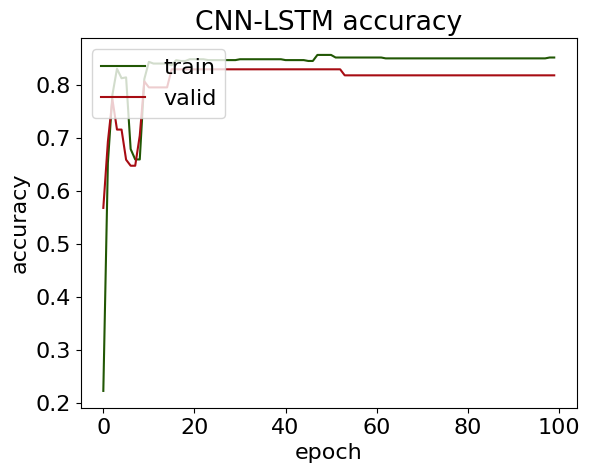

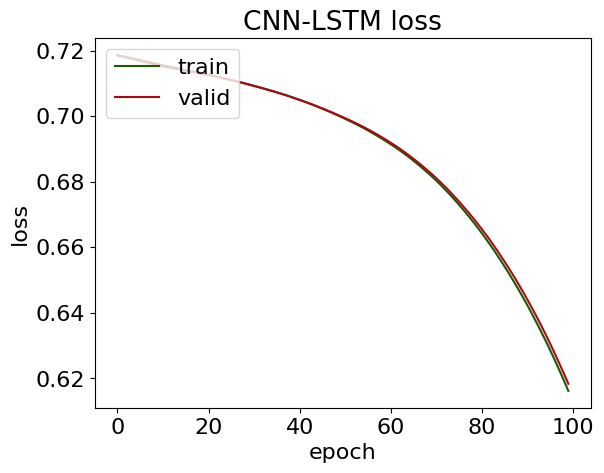

In [121]:
#plot for accuracy
plt.rcParams['font.size'] = 16
plt.plot(history_cnn_lstm.history['accuracy'], color='#215704')
plt.plot(history_cnn_lstm.history['val_accuracy'], color='#A70C13')
plt.title('CNN-LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#plot for loss
plt.plot(history_cnn_lstm.history['loss'], color='#215704')
plt.plot(history_cnn_lstm.history['val_loss'], color='#A70C13')
plt.title('CNN-LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [124]:
val_accuracy_list = np.array(history_cnn_lstm.history['val_accuracy'])
val_accuracy = round(np.mean(val_accuracy_list), 3)

val_precision_list = np.array(history_cnn_lstm.history['val_precision_2'])
val_precision = round(np.mean(val_precision_list), 3)

val_recall_list = np.array(history_cnn_lstm.history['val_recall_2'])
val_recall = round(np.mean(val_recall_list), 3)

val_f1_list = np.array(history_cnn_lstm.history['val_fbeta_score'])
val_f1 = round(np.mean(val_f1_list), 3)

In [125]:
y_pred_test = model_cnn_lstm.predict(x_test)

8/8 [==============================] - 1s 11ms/step


In [126]:
y_pred_test = list(map(lambda x: 0 if x<0.5 else 1, y_pred_test))

In [127]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

In [128]:
print("Scores training:")
print("Accuracy - ", round(accuracy_test, 3))
print("Precision - ", round(precision_test, 3))
print("Recall - ", round(recall_test, 3))
print("F1-score - ", round(f1_score_test, 3))

Scores training:
Accuracy -  0.846
Precision -  0.887
Recall -  0.797
F1-score -  0.839


In [129]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

In [130]:
pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
auc_pr = average_precision_score(y_test, y_pred_test)

In [131]:
brier = brier_score_loss(y_test, y_pred_test)

calib_true, calib_pred = calibration_curve(
    y_test, y_pred_test, n_bins=10, strategy="uniform"
)

metrics_list.append({'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1-score': f1_test,
                    'fpr': fpr_test,
                    'tpr': tpr_test,
                    'auc': roc_auc_test,
                    'auc_pr': auc_pr,
                    'pr_curve': pr_curve,
                    'rec_curve': rec_curve,
                    'thresholds_curve': thresholds_curve,
                    'brier': brier,
                    'calib_true': calib_true,
                    'calib_pred': calib_pred})

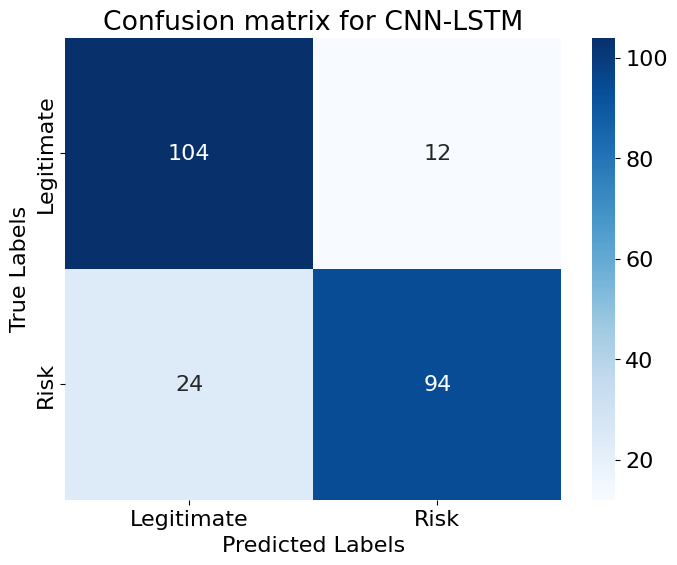

In [132]:
cm = confusion_matrix(y_test, y_pred_test, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels], yticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix for CNN-LSTM")
plt.show()

In [133]:
model_lstm_gru = Sequential()
model_lstm_gru.add(LSTM(128, input_shape=(7,1), return_sequences=True, kernel_regularizer=l2(1e-4)))
model_lstm_gru.add(SpatialDropout1D(0.25))
model_lstm_gru.add(GRU(64, kernel_regularizer=l2(1e-4)))
model_lstm_gru.add(Dropout(0.2))
model_lstm_gru.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model_lstm_gru.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', Precision(), Recall(), tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.9)])
model_lstm_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 128)            66560     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 7, 128)           0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 103,873
Trainable params: 103,873
Non-trainable params: 0
________________________________________________

In [134]:
start_train = time.perf_counter()

In [135]:
history_lstm_gru = model_lstm_gru.fit(x_train, y_train, batch_size = 14000, epochs = 100, verbose=1, validation_split=0.125)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.7025 - accuracy: 0.5081 - precision_3: 0.5017 - recall_3: 0.9967 - fbeta_score: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.6818 - val_precision_3: 0.6452 - val_recall_3: 0.8696 - val_fbeta_score: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 124ms/step - loss: 0.6960 - accuracy: 0.6840 - precision_3: 0.6190 - recall_3: 0.9408 - fbeta_score: 0.0000e+00 - val_loss: 0.6862 - val_accuracy: 0.6818 - val_precision_3: 0.6500 - val_recall_3: 0.8478 - val_fbeta_score: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 126ms/step - loss: 0.6893 - accuracy: 0.7199 - precision_3: 0.6500 - recall_3: 0.9408 - fbeta_score: 0.0000e+00 - val_loss: 0.6783 - val_accuracy: 0.6705 - val_precision_3: 0.6441 - val_recall_3: 0.8261 - val_fbeta_score: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 101ms/step - loss: 0.6827 - accuracy: 0.7345 - precision_3: 0.6749 - recall_3: 0.8947 - 

In [136]:
end_train = time.perf_counter()

total_training_time = end_train - start_train
avg_epoch_time = total_training_time / 100

print(f"Total training time (s): {total_training_time:.2f}")
print(f"Average training time per epoch (s): {avg_epoch_time:.2f}")

Total training time (s): 12.58
Average training time per epoch (s): 0.13


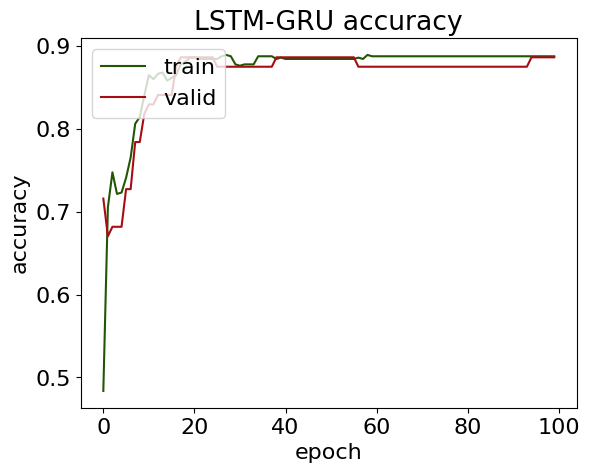

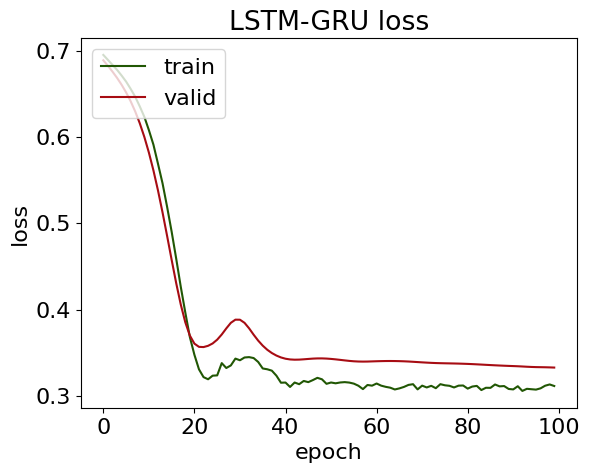

In [117]:
#plot for accuracy
plt.rcParams['font.size'] = 16
plt.plot(history_lstm_gru.history['accuracy'], color='#215704')
plt.plot(history_lstm_gru.history['val_accuracy'], color='#A70C13')
plt.title('LSTM-GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#plot for loss
plt.plot(history_lstm_gru.history['loss'], color='#215704')
plt.plot(history_lstm_gru.history['val_loss'], color='#A70C13')
plt.title('LSTM-GRU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [119]:
val_accuracy_list = np.array(history_lstm_gru.history['val_accuracy'])
val_accuracy = round(np.mean(val_accuracy_list), 3)

val_precision_list = np.array(history_lstm_gru.history['val_precision_4'])
val_precision = round(np.mean(val_precision_list), 3)

val_recall_list = np.array(history_lstm_gru.history['val_recall_4'])
val_recall = round(np.mean(val_recall_list), 3)

val_f1_list = np.array(history_lstm_gru.history['val_fbeta_score'])
val_f1 = round(np.mean(val_f1_list), 3)

In [120]:
y_pred_test = model_lstm_gru.predict(x_test)

8/8 [==============================] - 1s 9ms/step


In [121]:
y_pred_test = list(map(lambda x: 0 if x<0.5 else 1, y_pred_test))

In [122]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

In [123]:
print("Scores training:")
print("Accuracy - ", round(accuracy_test, 3))
print("Precision - ", round(precision_test, 3))
print("Recall - ", round(recall_test, 3))
print("F1-score - ", round(f1_score_test, 3))

Scores training:
Accuracy -  0.88
Precision -  0.941
Recall -  0.814
F1-score -  0.873


In [124]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

In [125]:
pr_curve, rec_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_test)
auc_pr = average_precision_score(y_test, y_pred_test)

In [126]:
brier = brier_score_loss(y_test, y_pred_test)

calib_true, calib_pred = calibration_curve(
    y_test, y_pred_test, n_bins=10, strategy="uniform"
)

metrics_list.append({'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1-score': f1_test,
                    'fpr': fpr_test,
                    'tpr': tpr_test,
                    'auc': roc_auc_test,
                    'auc_pr': auc_pr,
                    'pr_curve': pr_curve,
                    'rec_curve': rec_curve,
                    'thresholds_curve': thresholds_curve,
                    'brier': brier,
                    'calib_true': calib_true,
                    'calib_pred': calib_pred})

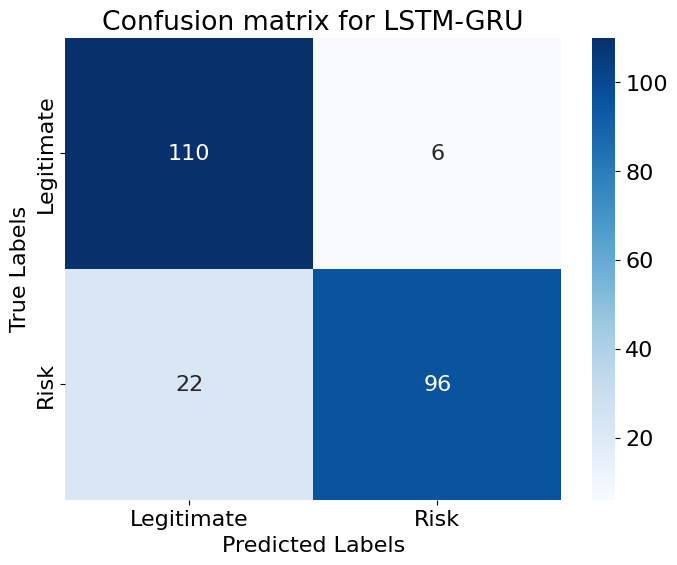

In [127]:
cm = confusion_matrix(y_test, y_pred_test, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels], yticklabels=["Legitimate" if lbl == 0 else "Risk" for lbl in labels])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix for LSTM-GRU")
plt.show()

In [128]:
len(metrics_list)

10

In [131]:
ML_DNN_models = ['Naive Bayes','Support vector machine','Decision tree','Random Forest','XGBoost','DNN','CNN','LSTM','CNN-LSTM','LSTM-GRU']

In [132]:
metrics_list

[{'Accuracy': 0.8461538461538461,
  'Precision': 0.7847222222222222,
  'Recall': 0.9576271186440678,
  'F1-score': 0.8625954198473282,
  'fpr': array([0.        , 0.26724138, 1.        ]),
  'tpr': array([0.        , 0.95762712, 1.        ]),
  'auc': 0.8451928696668616,
  'auc_pr': 0.772838801970158,
  'pr_curve': array([0.5042735 , 0.78472222, 1.        ]),
  'rec_curve': array([1.        , 0.95762712, 0.        ]),
  'thresholds_curve': array([0, 1], dtype=int64),
  'brier': 0.15384615384615385,
  'calib_true': array([0.05555556, 0.78472222]),
  'calib_pred': array([0., 1.])},
 {'Accuracy': 0.9487179487179487,
  'Precision': 0.9416666666666667,
  'Recall': 0.9576271186440678,
  'F1-score': 0.9495798319327731,
  'fpr': array([0.        , 0.06034483, 1.        ]),
  'tpr': array([0.        , 0.95762712, 1.        ]),
  'auc': 0.9486411455289305,
  'auc_pr': 0.9231330580906852,
  'pr_curve': array([0.5042735 , 0.94166667, 1.        ]),
  'rec_curve': array([1.        , 0.95762712, 0.  

In [133]:
data_bar = pd.DataFrame(metrics_list, index=ML_DNN_models)

In [134]:
data_bar

,Accuracy,Precision,Recall,F1-score,fpr,tpr,auc,auc_pr,pr_curve,rec_curve,thresholds_curve,brier,calib_true,calib_pred
Naive Bayes,0.846154,0.784722,0.957627,0.862595,"[0.0, 0.2672413793103448, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.845193,0.772839,"[0.5042735042735043, 0.7847222222222222, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.153846,"[0.05555555555555555, 0.7847222222222222]","[0.0, 1.0]"
Support vector machine,0.948718,0.941667,0.957627,0.949580,"[0.0, 0.0603448275862069, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.948641,0.923133,"[0.5042735042735043, 0.9416666666666667, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.051282,"[0.043859649122807015, 0.9416666666666667]","[0.0, 1.0]"
Decision tree,0.957265,0.957627,0.957627,0.957627,"[0.0, 0.04310344827586207, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.957262,0.938417,"[0.5042735042735043, 0.9576271186440678, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.042735,"[0.04310344827586207, 0.9576271186440678]","[0.0, 1.0]"
Random Forest,0.944444,0.956522,0.932203,0.944206,"[0.0, 0.04310344827586207, 1.0]","[0.0, 0.9322033898305084, 1.0]",0.944550,0.925861,"[0.5042735042735043, 0.9565217391304348, 1.0]","[1.0, 0.9322033898305084, 0.0]","[0, 1]",0.055556,"[0.06722689075630252, 0.9565217391304348]","[0.0, 1.0]"
XGBoost,0.944444,0.933884,0.957627,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.915680,"[0.5042735042735043, 0.9338842975206612, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.055556,"[0.04424778761061947, 0.9338842975206612]","[0.0, 1.0]"
DNN,0.948718,0.934426,0.966102,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.919845,"[0.5042735042735043, 0.9344262295081968, 1.0]","[1.0, 0.9661016949152542, 0.0]","[0, 1]",0.051282,"[0.03571428571428571, 0.9344262295081968]","[0.0, 1.0]"
CNN,0.833333,0.843478,0.822034,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.783111,"[0.5042735042735043, 0.8434782608695652, 1.0]","[1.0, 0.8220338983050848, 0.0]","[0, 1]",0.166667,"[0.17647058823529413, 0.8434782608695652]","[0.0, 1.0]"
LSTM,0.880342,0.941176,0.813559,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.859720,"[0.5042735042735043, 0.9411764705882353, 1.0]","[1.0, 0.8135593220338984, 0.0]","[0, 1]",0.119658,"[0.16666666666666666, 0.9411764705882353]","[0.0, 1.0]"
CNN-LSTM,0.829060,0.933333,0.711864,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.809706,"[0.5042735042735043, 0.9333333333333333, 1.0]","[1.0, 0.711864406779661, 0.0]","[0, 1]",0.170940,"[0.2361111111111111, 0.9333333333333333]","[0.0, 1.0]"
LSTM-GRU,0.880342,0.941176,0.813559,0.945607,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.859720,"[0.5042735042735043, 0.9411764705882353, 1.0]","[1.0, 0.8135593220338984, 0.0]","[0, 1]",0.119658,"[0.16666666666666666, 0.9411764705882353]","[0.0, 1.0]"


In [135]:
data_fpr_tpr = pd.DataFrame(metrics_list, index=ML_DNN_models)
data_fpr_tpr.drop(['Accuracy','Precision','Recall','F1-score'], axis=1, inplace=True)

In [136]:
data_bar.drop(['fpr','tpr','auc'], axis=1, inplace=True)

In [137]:
tpr_list = data_fpr_tpr['tpr'].to_list()
fpr_list = data_fpr_tpr['fpr'].to_list()

In [138]:
tpr_list

[array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.93220339, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ]),
 array([0.        , 0.95762712, 1.        ])]

In [139]:
auc_roc_list = data_fpr_tpr['auc'].values

In [140]:
auc_roc_list

array([0.84519287, 0.94864115, 0.95726184, 0.94454997, 0.9443308 ,
       0.9443308 , 0.9443308 , 0.9443308 , 0.9443308 , 0.9443308 ])

In [141]:
auc_pr_list = data_fpr_tpr['auc_pr'].values

In [142]:
precision_list = data_bar['Precision']
recall_list = data_bar['Recall']

In [143]:
data_fpr_tpr

,fpr,tpr,auc,auc_pr,pr_curve,rec_curve,thresholds_curve,brier,calib_true,calib_pred
Naive Bayes,"[0.0, 0.2672413793103448, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.845193,0.772839,"[0.5042735042735043, 0.7847222222222222, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.153846,"[0.05555555555555555, 0.7847222222222222]","[0.0, 1.0]"
Support vector machine,"[0.0, 0.0603448275862069, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.948641,0.923133,"[0.5042735042735043, 0.9416666666666667, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.051282,"[0.043859649122807015, 0.9416666666666667]","[0.0, 1.0]"
Decision tree,"[0.0, 0.04310344827586207, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.957262,0.938417,"[0.5042735042735043, 0.9576271186440678, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.042735,"[0.04310344827586207, 0.9576271186440678]","[0.0, 1.0]"
Random Forest,"[0.0, 0.04310344827586207, 1.0]","[0.0, 0.9322033898305084, 1.0]",0.944550,0.925861,"[0.5042735042735043, 0.9565217391304348, 1.0]","[1.0, 0.9322033898305084, 0.0]","[0, 1]",0.055556,"[0.06722689075630252, 0.9565217391304348]","[0.0, 1.0]"
XGBoost,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.915680,"[0.5042735042735043, 0.9338842975206612, 1.0]","[1.0, 0.9576271186440678, 0.0]","[0, 1]",0.055556,"[0.04424778761061947, 0.9338842975206612]","[0.0, 1.0]"
DNN,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.919845,"[0.5042735042735043, 0.9344262295081968, 1.0]","[1.0, 0.9661016949152542, 0.0]","[0, 1]",0.051282,"[0.03571428571428571, 0.9344262295081968]","[0.0, 1.0]"
CNN,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.783111,"[0.5042735042735043, 0.8434782608695652, 1.0]","[1.0, 0.8220338983050848, 0.0]","[0, 1]",0.166667,"[0.17647058823529413, 0.8434782608695652]","[0.0, 1.0]"
LSTM,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.859720,"[0.5042735042735043, 0.9411764705882353, 1.0]","[1.0, 0.8135593220338984, 0.0]","[0, 1]",0.119658,"[0.16666666666666666, 0.9411764705882353]","[0.0, 1.0]"
CNN-LSTM,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.809706,"[0.5042735042735043, 0.9333333333333333, 1.0]","[1.0, 0.711864406779661, 0.0]","[0, 1]",0.170940,"[0.2361111111111111, 0.9333333333333333]","[0.0, 1.0]"
LSTM-GRU,"[0.0, 0.06896551724137931, 1.0]","[0.0, 0.9576271186440678, 1.0]",0.944331,0.859720,"[0.5042735042735043, 0.9411764705882353, 1.0]","[1.0, 0.8135593220338984, 0.0]","[0, 1]",0.119658,"[0.16666666666666666, 0.9411764705882353]","[0.0, 1.0]"


In [144]:
pr_curve_list = data_fpr_tpr['pr_curve']
rec_curve_list = data_fpr_tpr['rec_curve']
brier_list = data_fpr_tpr['brier']
calib_true_list = data_fpr_tpr['calib_true']
calib_pred_list = data_fpr_tpr['calib_pred']

In [145]:
clrs2 = ['green', 'orange', 'red', 'blue', 'cyan', '#E02BE0', '#57BFFA', '#74bdcb', '#ffaebc', '#60a3d9']

In [146]:
bar_plot_data = pd.DataFrame({
    "Accuracy": data_bar["Accuracy"].values,
    "Precision": data_bar["Precision"].values,
    "Recall": data_bar["Recall"].values,
    "F1-score": data_bar["F1-score"].values
    },
    index=['Naive Bayes','Support vector machine','Decision tree','Random Forest','XGBoost','DNN','CNN','LSTM','CNN-LSTM','LSTM-GRU']
)

C:\Users\Vladislav\AppData\Local\Temp\ipykernel_22684\1734466116.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rec_curve_list[i],
C:\Users\Vladislav\AppData\Local\Temp\ipykernel_22684\1734466116.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pr_curve_list[i],
C:\Users\Vladislav\AppData\Local\Temp\ipykernel_22684\1734466116.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  calib_pred_list[i],
C:\Users\Vladislav\AppDat

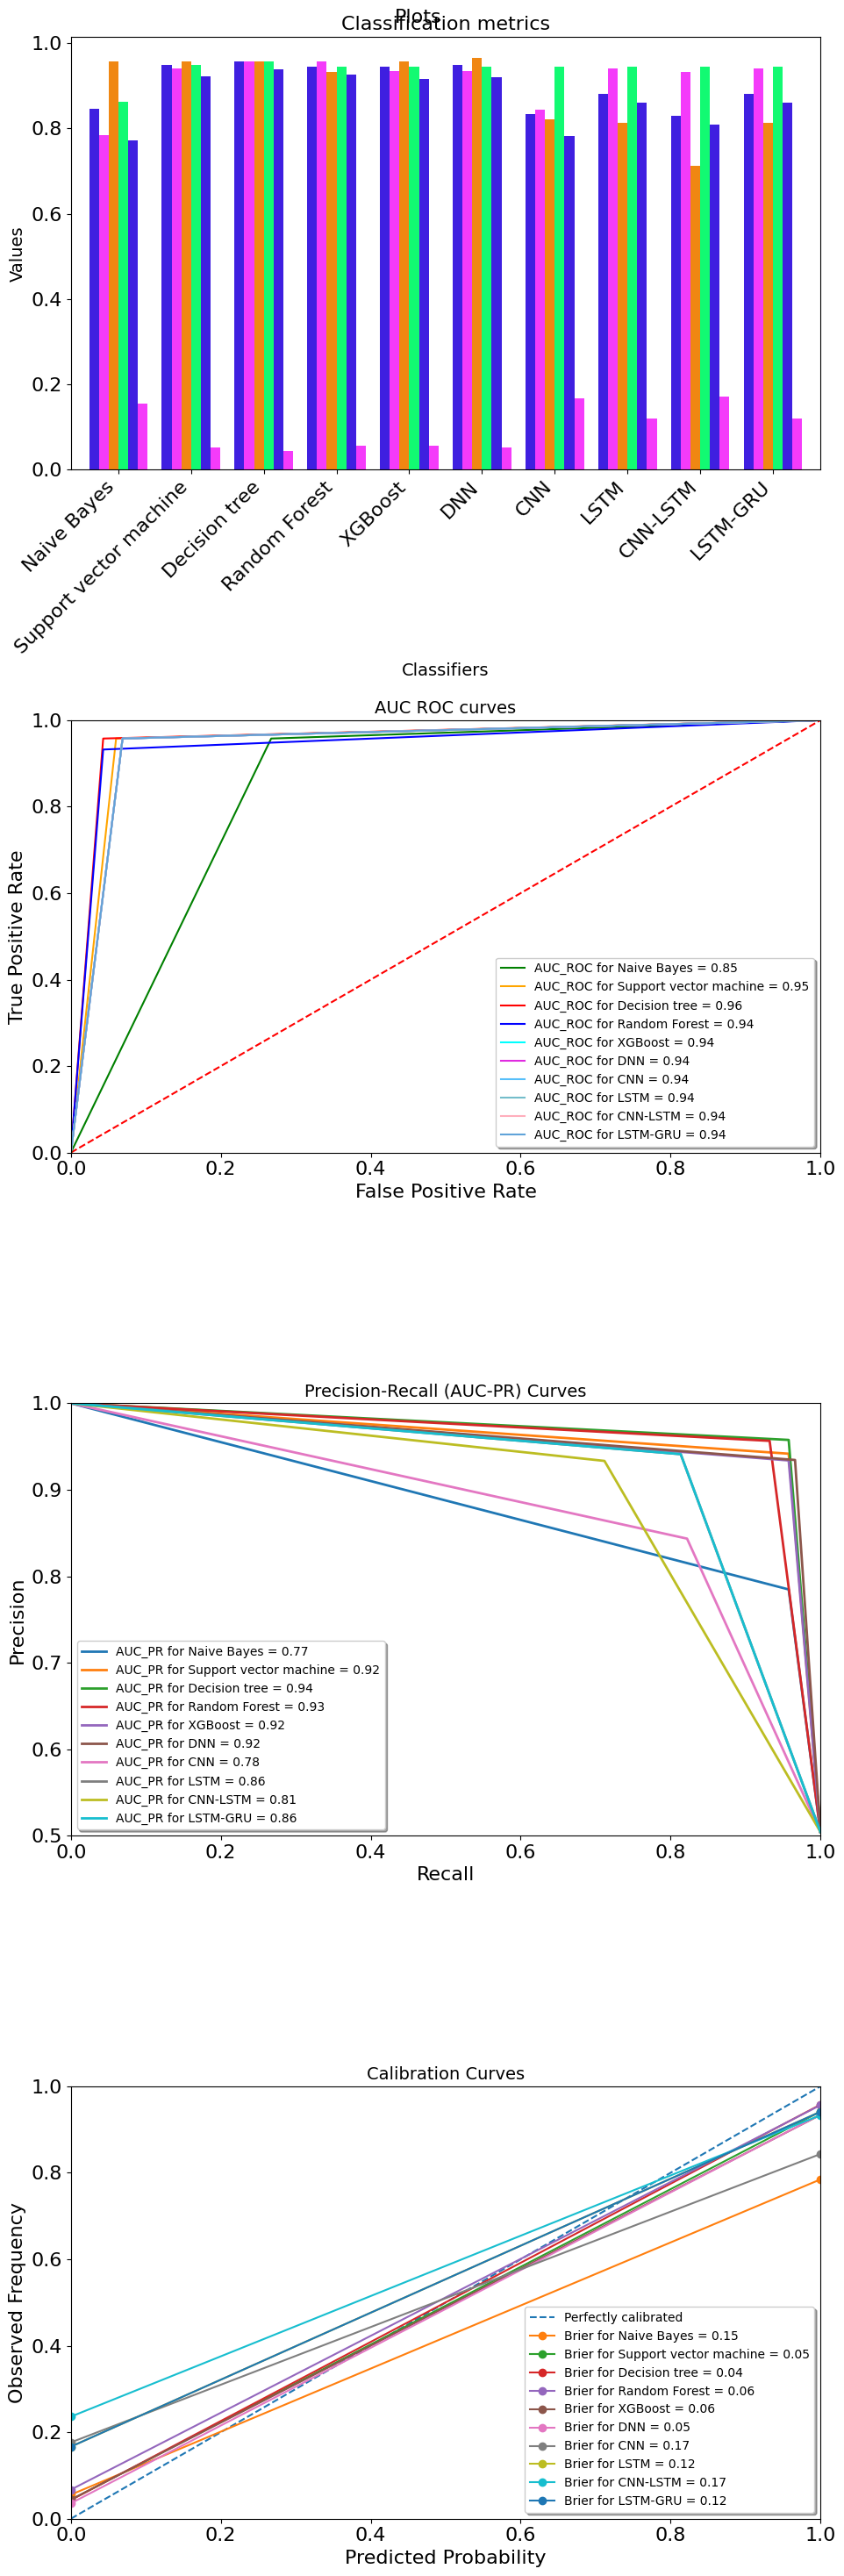

In [147]:
fig, axes = plt.subplots(4, 1, figsize=(10,30))
fig.suptitle('Plots', fontsize = 16)
axes[0].set_title('Classification metrics', fontsize = 16)
clrs = ['#3F1FE0',  '#F43BFA', '#F08712', '#12FA72']
data_bar.plot(kind="bar", ax=axes[0], color=clrs, width=0.8)
axes[0].set_xlabel('Classifiers', fontsize = 14)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylabel('Values', fontsize = 14)
axes[0].legend().remove()

axes[1].set_title('AUC ROC curves', fontsize = 14)
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate', fontsize = 16)
axes[1].set_xlabel('False Positive Rate', fontsize = 16)
for i in range(len(auc_roc_list)):
    axes[1].plot(fpr_list[i], tpr_list[i], clrs2[i], label = 'AUC_ROC for ' + ML_DNN_models[i] + ' = %0.2f' % auc_roc_list[i])

axes[1].legend(loc = 'lower right', fancybox=True, fontsize=10, shadow = True)

axes[2].set_title('Precision-Recall (AUC-PR) Curves', fontsize=14)

axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.5, 1.0])

axes[2].set_xlabel('Recall', fontsize=16)
axes[2].set_ylabel('Precision', fontsize=16)

for i in range(len(auc_pr_list)):
    axes[2].plot(
        rec_curve_list[i],
        pr_curve_list[i],
        linewidth=2,           
        label=f"AUC_PR for {ML_DNN_models[i]} = {auc_pr_list[i]:.2f}"
    )

axes[2].legend(loc='lower left', fancybox=True, fontsize=10, shadow=True)

axes[3].set_title('Calibration Curves', fontsize=14)
axes[3].set_xlim([0.0, 1.0])
axes[3].set_ylim([0.0, 1.0])
axes[3].set_xlabel('Predicted Probability', fontsize=16)
axes[3].set_ylabel('Observed Frequency', fontsize=16)
axes[3].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

for i in range(len(brier_list)):
    axes[3].plot(
        calib_pred_list[i],
        calib_true_list[i],
        marker='o',
        label=f"Brier for {ML_DNN_models[i]} = {brier_list[i]:.2f}"
    )

axes[3].legend(loc='lower right', fancybox=True, fontsize=10, shadow=True)

fig.tight_layout()
plt.show()

# Conducting t-test